# Buchdichte in Berlin

## Daten von Das Örtliche

Die Adressen der Buchhandlungen werden von den Seiten von [Das Örtliche](www.dasoertliche.de) bezogen.

In [40]:
import requests
from lxml import etree
import re
from collections import Counter, defaultdict

In [22]:
FROM = 1

In [23]:
oertliche = f"https://www.dasoertliche.de/?seo=true&zvo_ok=0&buc=&plz=&quarter=&district=&ciid=&fn=&kw=Buchhandlungen&ci=Berlin&st=&radius=0&kgs=&buab=&zbuab=&form_name=search_nat_ext&recFrom={FROM}"

In [24]:
res = requests.get(oertliche)

In [25]:
parser = etree.HTMLParser()
tree   = etree.fromstring(res.text, parser)

In [26]:
total_hits = int(tree.find('.//span[@class="sttrefferanz"]').text)

In [30]:
def parseResponse(res) -> list:
    '''Liest HTTP-Response von Das Örtliche aus und gibt eine '''
    tree   = etree.fromstring(res.text, parser)
    results = []
    for div in tree.findall('.//div[@class = "hit "]'):
        name = div.find('h2/a').text.strip()
        link = div.find('h2/a').attrib.get('href').strip()
        tmp_address = div.find('.//address')
        address = []
        for x in tmp_address.iter():
            if x.text is not None:
                text = x.text.strip()
                if len(text) > 0:
                    address.append(text)
            if x.tail is not None:
                tail = x.tail.strip()
                if len(tail) > 0:
                    address.append(tail)
        for a in address:
            PLZ = None
            try:
                PLZ = re.search(r'1\d{4}',a).group()
            except Exception as e:
                print(e)

        results.append({
            'name' : name,
            'link' : link,
            'address' : address,
            'PLZ' : PLZ
        })
    return results

In [31]:
buchhandlungen = []

In [32]:
for FROM in range(1,total_hits + 1, 25):
    oertliche = f"https://www.dasoertliche.de/?seo=true&zvo_ok=0&buc=&plz=&quarter=&district=&ciid=&fn=&kw=Buchhandlungen&ci=Berlin&st=&radius=0&kgs=&buab=&zbuab=&form_name=search_nat_ext&recFrom={FROM}"
    res = requests.get(oertliche)
    _ = parseResponse(res)
    buchhandlungen.extend(_)

'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' 

'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' 

'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'


In [41]:
bhCounter = Counter(b.get('PLZ') for b in buchhandlungen)

## Bevölkerungsstatistik

https://www.statistik-berlin-brandenburg.de/a-i-5-hj

In [35]:
import pandas as pd
from io import BytesIO

In [36]:
url = "https://download.statistik-berlin-brandenburg.de/31b0e1f55fbede61/0a9d61e4323b/SB_A01-05-00_2022h01_BE.xlsx"
res = requests.get(url)

In [37]:
df = pd.read_excel(BytesIO(res.content),
                   sheet_name = "T14",
                   skiprows = lambda x: x in [0,1,3,4],
                   converters = {
                       'Postleitzahl' : str,
                       'Ins-\ngesamt' : int
                   },
                   nrows = 237
                  )

In [39]:
bevoelkerung = defaultdict(int)

In [42]:
for plz,pop in zip(df['Postleitzahl'],df['Ins-\ngesamt']):
    bevoelkerung[plz] += pop

## Buchladendichte

In [43]:
dichte = dict()
for plz,pop in bevoelkerung.items():
    bh = bhCounter.get(plz,0)  
    try:
        dichte[plz] = bh/pop
    except Exception as e:
        print(e)

In [44]:
from matplotlib import pyplot as plt

In [45]:
xs = []
ys = []
for n,(plz, bhdichte) in enumerate(sorted(dichte.items(), key = lambda x:x[1], reverse = True)):
    if n < 11:
    #if len(dichte) * 0.2 < n < len(dichte) * 0.8:
        xs.append(plz)
        ys.append(bhdichte * 10000)

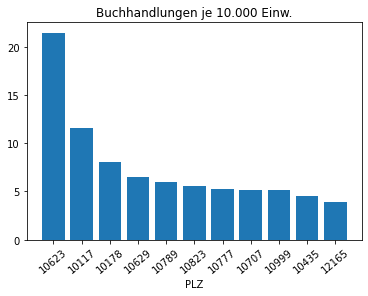

In [46]:
plt.bar(xs,ys)
plt.title("Buchhandlungen je 10.000 Einw.")
plt.xlabel("PLZ")
plt.xticks(rotation=40, ha = "center")
plt.show()

### CSV-Export

In [47]:
with open("buchladendichteBerlin.csv","w") as OUT:
    for plz,bhdichte in dichte.items():
        print(f"{plz},{bh}", file = OUT)

### Visualisierung auf einer Karte

Koordinaten zu ostleitzahlen zu finden bei [ODIS](https://daten.odis-berlin.de/de/dataset/plz/)

In [48]:
geojson = requests.get("https://tsb-opendata.s3.eu-central-1.amazonaws.com/plz/plz.geojson").json()

In [49]:
plzPolygons = {}
for _ in geojson.get('features'):
    plz = _.get('properties').get('plz')
    vertices = []
    for c1 in _.get('geometry').get('coordinates'):
        for c2 in c1:
            vertices.append(c2)
    plzPolygons[plz] = vertices

In [69]:
import matplotlib

In [52]:
from matplotlib import cm

In [114]:
minimum = min([v * 10000 for v in dichte.values()])
maximum = max([v * 10000 for v in dichte.values()])

norm = matplotlib.colors.Normalize(vmin=minimum, vmax=maximum, clip=True)

too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
'15537'
'15566'
'15569'


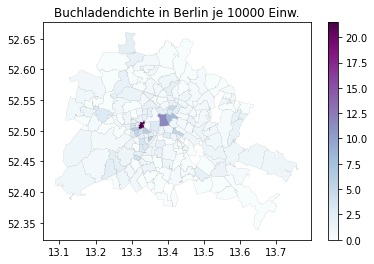

In [128]:
plt.figure()
viridis = cm.get_cmap('BuPu', 256)
for k,v in plzPolygons.items():
    try:
        xs,ys = zip(*v)
        plt.fill(xs,ys, facecolor = viridis(norm(dichte[k]*10000)), edgecolor = 'grey', linewidth = 0.1)
    except Exception as e:
        print(e)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=viridis))
plt.title("Buchladendichte in Berlin je 10000 Einw.")
plt.show()